#LSTM 과 GPU
- 등장 이유 : 긴 기간의 의존성 -> 정보의 희석화, 문장이 길어질 시 얻고자 하는 정보를 찾는데 시간이 오래 걸림

- CELL STATE 와 3개의 GATE 로 구성

#LSTM의  구조
- 셀상태 : 다음 층으로 전달 되지 않고, 해당 셀에서만 순환

- 삭제 게이트 : 입력과 전달받은 은닉상태를 받아 시그모이드 함수에 넣어 결과를 이전 셀과 곱 ( 과거 정보를 잊기 위한 FORGET GATE)

- 입력 게이트 : 받은 데이터를 하나는 시그모이드, 하나는 TANH에 넣어 결과를 이전 삭제 게이트에서 나온 값과 합 ( 현재 정보를 기억하기 위한 INPUT GATE)



- 출력 게이트 : 위 두 단계의 결과를 TANH에 넣고, 받은 데이터를 시그모이드에 넣어서 곱한 걸 은닉 상태로 출력

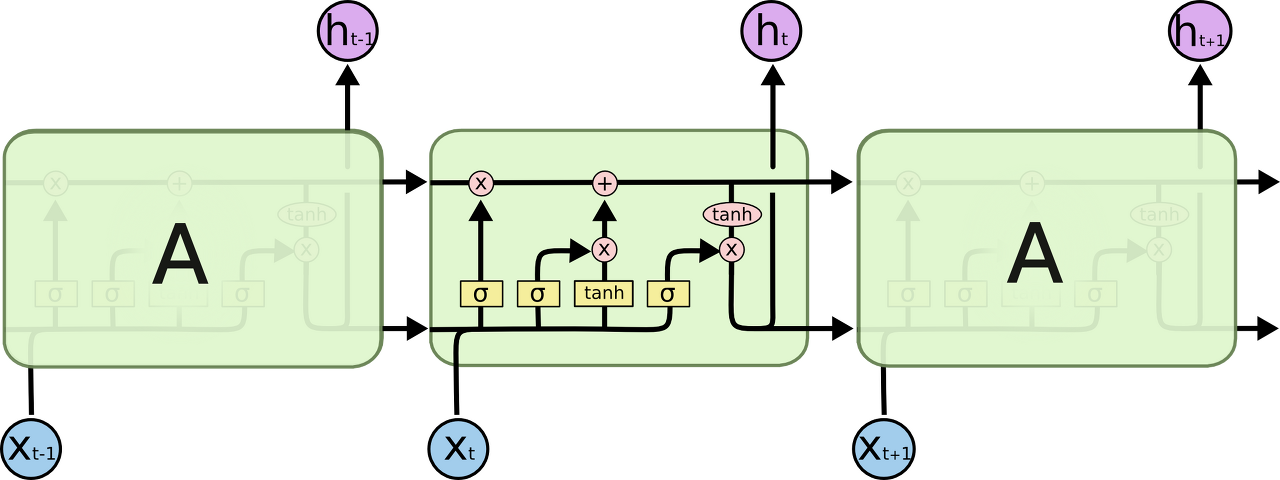

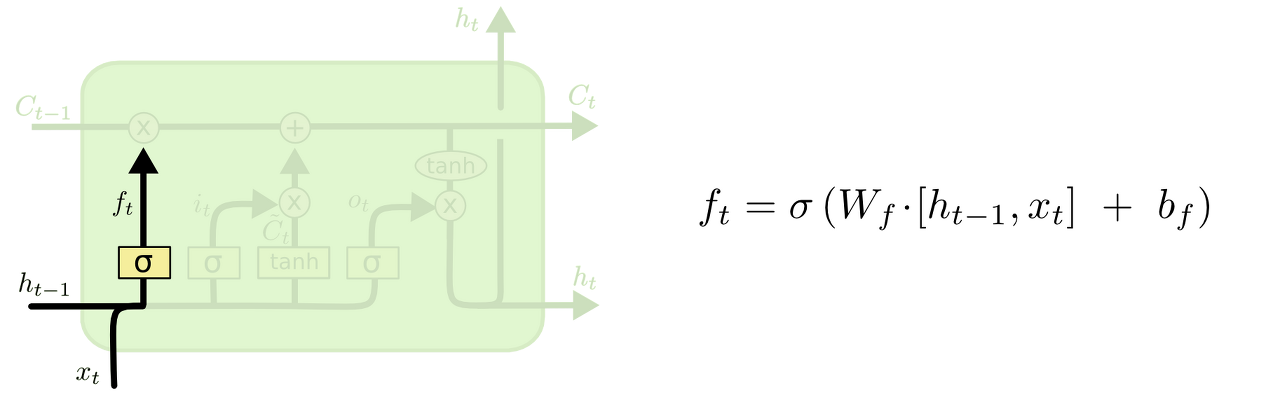

![image.png](
)

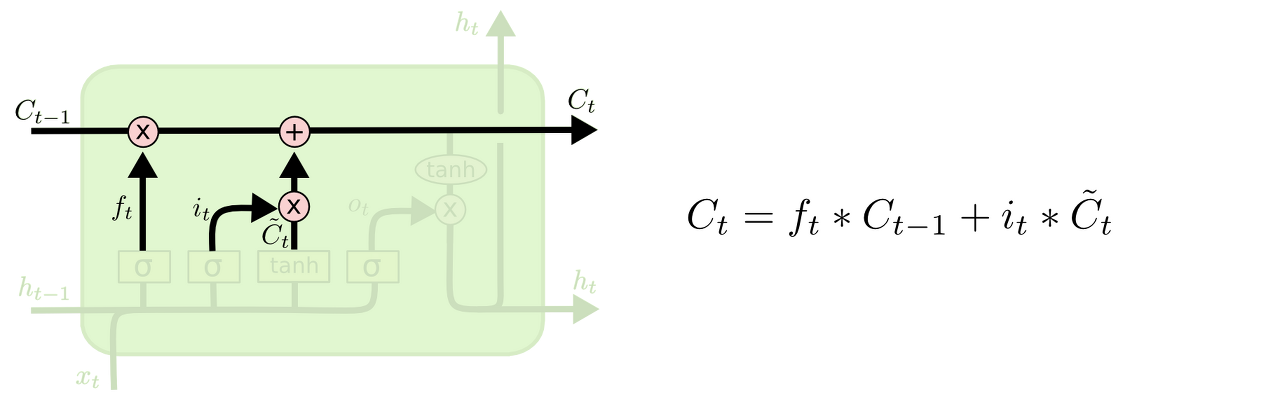


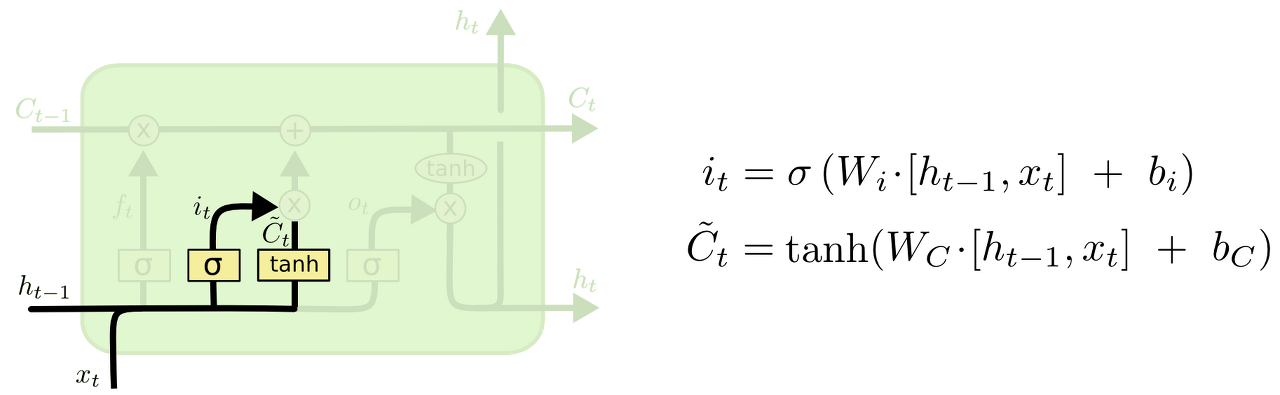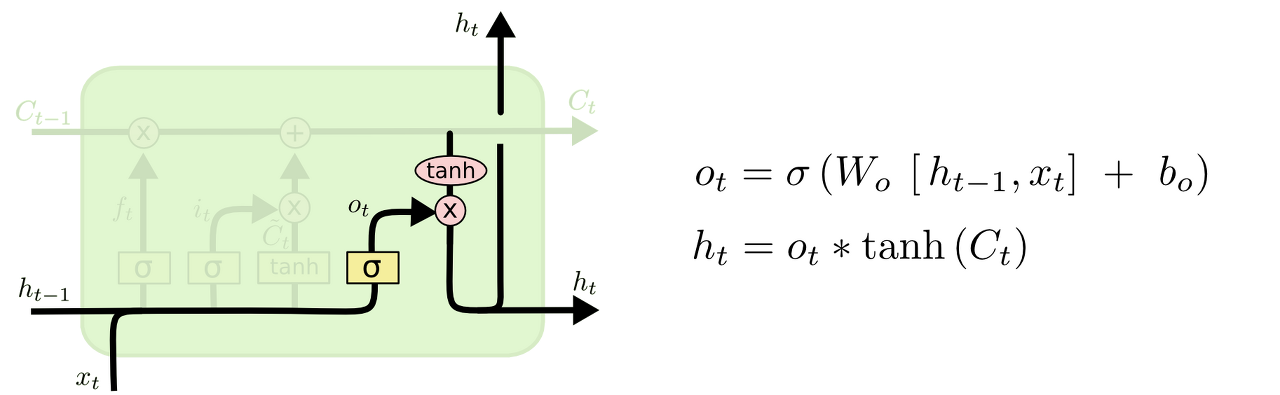

1-3-2-4 순으로 ( 그림 순서 잘못 넣음)


In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input,train_target),(test_input,test_target) = imdb.load_data(num_words = 500) #사용 단어 종류 500개
train_input,val_input,train_target,val_target = train_test_split(train_input,train_target, test_size = 0.2, random_state = 42)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100) #길이 100으로 줄임
val_seq = pad_sequences(val_input, maxlen = 100)

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500,16,input_length =100)) #단어 종류 개수, 변환할 벡터 크기, 입력 크기
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model.summary()  #500*16 + (16*8 + 8*8 + 8)*4 + 92 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy',metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-modle.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3,restore_best_weights = True)
history = model.fit(train_seq,train_target,epochs = 100,batch_size = 64, 
                    validation_data = (val_seq,val_target),
                    callbacks = [checkpoint_cb,early_stopping_cb]) #배치크기 = 해당 샘플의 수마다 가중치 업데이트

Epoch 1/100
313/313 [==============================] - 14s 38ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6923 - val_accuracy: 0.5480
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6917 - accuracy: 0.5847 - val_loss: 0.6897 - val_accuracy: 0.6346
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6873 - accuracy: 0.6629 - val_loss: 0.6745 - val_accuracy: 0.7164
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6606 - accuracy: 0.7211 - val_loss: 0.6280 - val_accuracy: 0.7090
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6191 - accuracy: 0.7125 - val_loss: 0.6091 - val_accuracy: 0.7130
Epoch 6/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5957 - accuracy: 0.7314 - val_loss: 0.5889 - val_accuracy: 0.7336
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5798 - accuracy: 0.7378 - val_loss: 0.5712 - val_ac

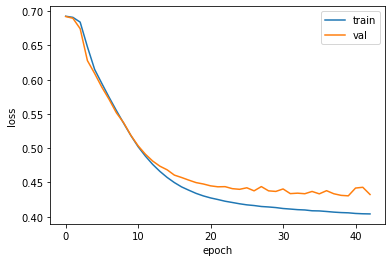

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

#드롭아웃 적용하기

- 매개변수를 통해 적용

- dropout : 입력 데이터에 드롭아웃

- recurrent_dropout = 순환되는 은닉상태에 드롭아웃

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500,16,input_length =100)) #단어 종류 개수, 변환할 벡터 크기, 입력 크기
model2.add(keras.layers.LSTM(8,dropout = 0.3)) #30% 드롭아웃
model2.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy',metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-modle.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
history = model.fit(train_seq,train_target,epochs = 100,batch_size = 64, 
                    validation_data = (val_seq,val_target),
                    callbacks = [checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 37ms/step - loss: 0.4050 - accuracy: 0.8179 - val_loss: 0.4302 - val_accuracy: 0.8012
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 0.4041 - accuracy: 0.8174 - val_loss: 0.4351 - val_accuracy: 0.7944
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.4040 - accuracy: 0.8173 - val_loss: 0.4302 - val_accuracy: 0.8042
Epoch 4/100
313/313 [==============================] - 11s 37ms/step - loss: 0.4031 - accuracy: 0.8176 - val_loss: 0.4297 - val_accuracy: 0.8004
Epoch 5/100
313/313 [==============================] - 12s 38ms/step - loss: 0.4026 - accuracy: 0.8181 - val_loss: 0.4314 - val_accuracy: 0.7996
Epoch 6/100
313/313 [==============================] - 11s 37ms/step - loss: 0.4015 - accuracy: 0.8184 - val_loss: 0.4308 - val_accuracy: 0.7996
Epoch 7/100
313/313 [==============================] - 11s 36ms/step - loss: 0.4012 - accuracy: 0.8177 - val_loss: 0.4279 - val_ac

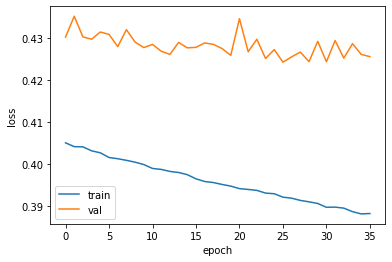

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 층 연결하기

In [ ]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500,16,input_length =100)) 
model3.add(keras.layers.LSTM(8,dropout = 0.3,return_sequences = True)) 
model3.add(keras.layers.LSTM(8,dropout = 0.3)) 
model3.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model3.compile(optimizer = rmsprop, loss = 'binary_crossentropy',metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-modle.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
history = model.fit(train_seq,train_target,epochs = 100,batch_size = 64, 
                    validation_data = (val_seq,val_target),
                    callbacks = [checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 38ms/step - loss: 0.3917 - accuracy: 0.8212 - val_loss: 0.4295 - val_accuracy: 0.8028
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3906 - accuracy: 0.8224 - val_loss: 0.4261 - val_accuracy: 0.8026
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3910 - accuracy: 0.8224 - val_loss: 0.4296 - val_accuracy: 0.8044
Epoch 4/100
313/313 [==============================] - 12s 38ms/step - loss: 0.3904 - accuracy: 0.8210 - val_loss: 0.4249 - val_accuracy: 0.8030
Epoch 5/100
313/313 [==============================] - 12s 38ms/step - loss: 0.3899 - accuracy: 0.8225 - val_loss: 0.4264 - val_accuracy: 0.8026
Epoch 6/100
313/313 [==============================] - 11s 37ms/step - loss: 0.3898 - accuracy: 0.8240 - val_loss: 0.4282 - val_accuracy: 0.8016
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3893 - accuracy: 0.8228 - val_loss: 0.4276 - val_ac

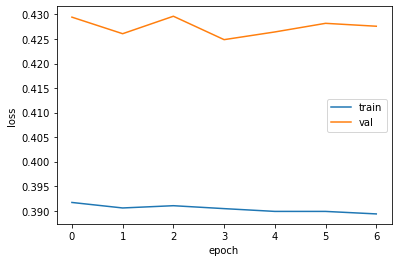

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

#gru 모델
- lstm의 간소화 버전
- update gate 와 reset gate로 구성

In [ ]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500,16,input_length =100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss = 'binary_crossentropy',metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-modle.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3,restore_best_weights = True)
history = model.fit(train_seq,train_target,epochs = 100,batch_size = 64, 
                    validation_data = (val_seq,val_target),
                    callbacks = [checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3903 - accuracy: 0.8227 - val_loss: 0.4259 - val_accuracy: 0.8040
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3896 - accuracy: 0.8230 - val_loss: 0.4266 - val_accuracy: 0.8042
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3894 - accuracy: 0.8218 - val_loss: 0.4266 - val_accuracy: 0.8052
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3889 - accuracy: 0.8234 - val_loss: 0.4267 - val_accuracy: 0.8042


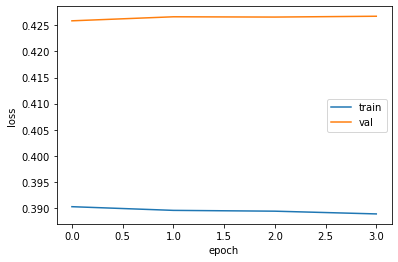

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()